assined clusters: [0, 1, 1, 2, 1, 1, 2, 2, 1, 1, 0, 1, 1, 2, 2, 1, 0, 2, 2, 2, 0, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 1, 2, 0, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
time is: 89.47725582122803


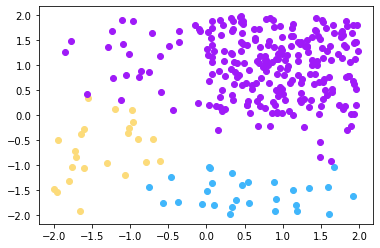

In [11]:
import numpy as np
import random
import time

STOP_THRESHOLD = 1e-4
# STOP_THRESHOLD = 1e-2
CLUSTER_THRESHOLD = 1e-1

def distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def gaussian_kernel(distance, bandwidth):
    return (1 / (bandwidth * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((distance / bandwidth)) ** 2)

class MeanShift(object):
    def __init__(self, kernel=gaussian_kernel):
        self.kernel = kernel

    def fit(self, points, kernel_bandwidth):

        shift_points = np.array(points)
        shifting = [True] * points.shape[0]

        while True:
            max_dist = 0
            for i in range(0, len(shift_points)):
                if not shifting[i]:
                    continue
                p_shift_init = shift_points[i].copy()
                shift_points[i] = self._shift_point(shift_points[i], points, kernel_bandwidth)
                dist = distance(shift_points[i], p_shift_init)
                max_dist = max(max_dist, dist)
                shifting[i] = dist > STOP_THRESHOLD

            if(max_dist < STOP_THRESHOLD):
                break
        cluster_ids = self._cluster_points(shift_points.tolist())
        return shift_points, cluster_ids

    def _shift_point(self, point, points, kernel_bandwidth):
        shift_x = 0.0
        shift_y = 0.0
        scale = 0.0
        for p in points:
            dist = distance(point, p)
            weight = self.kernel(dist, kernel_bandwidth)
            shift_x += p[0] * weight
            shift_y += p[1] * weight
            scale += weight
        shift_x = shift_x / scale
        shift_y = shift_y / scale
        return [shift_x, shift_y]

    def _cluster_points(self, points):
        cluster_ids = []
        cluster_idx = 0
        cluster_centers = []

        for i, point in enumerate(points):
            if(len(cluster_ids) == 0):
                cluster_ids.append(cluster_idx)
                cluster_centers.append(point)
                cluster_idx += 1
            else:
                for center in cluster_centers:
                    dist = distance(point, center)
                    if(dist < CLUSTER_THRESHOLD):
                        cluster_ids.append(cluster_centers.index(center))
                if(len(cluster_ids) < i + 1):
                    cluster_ids.append(cluster_idx)
                    cluster_centers.append(point)
                    cluster_idx += 1
        return cluster_ids


from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt

def colors(n):
  ret = []
  for i in range(n):
    ret.append((random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))
  return ret

def main():
    centers = [[-1, -1], [-1, 1], [1, -1], [1, 1]]
    X, _ = make_blobs(n_samples=300, centers=centers, cluster_std=0.4)

    # 这个是我自己创建的随机数据，需6分钟才能跑完
    np.random.seed(2332)
    b=np.random.uniform(0,2,(200,2))
    a=np.random.uniform(-2,2,(100,2))
    X=np.vstack((a,b))


    mean_shifter = MeanShift()
    # bandwidth修改之后，显著提升效率，但是聚类基本相当于没有
    # 奇怪，0.25也挺快的，但是0.5特别慢，只分两类
    _, mean_shift_result = mean_shifter.fit(X, kernel_bandwidth=0.4)

    np.set_printoptions(precision=3)
    # print('input: {}'.format(X))
    print('assined clusters: {}'.format(mean_shift_result))
    color = colors(np.unique(mean_shift_result).size)

    for i in range(len(mean_shift_result)):
        plt.scatter(X[i, 0], X[i, 1], color = color[mean_shift_result[i]])
    plt.show()

if __name__ == '__main__':
    t=time.time()
    main()
    print('time is:',time.time()-t)